In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings


warnings.filterwarnings("ignore")


# Extra settings
# # 设置中文字体
mpl.rcParams['font.family'] = 'simsun'
# 设置负号显示
mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8


In [18]:
from db.getdata import get_conn, get_temp_employee_data, get_temp_data
import pymssql
# from db.config import settings
try:

    conn = pymssql.connect(
            host="192.168.89.43",
            user="datalab",
            password="Lab!#21",
            database="hr",
            as_dict=True,
            tds_version="7.0" #TDS 协议的版本号，用于指定与数据库服务器通信所使用的 TDS 协议版本。
        )
except Exception as e:
    print(e)
employee_data = get_temp_employee_data(conn)
depart_data = get_temp_data(conn, "2021-01-01", "2023-12-31")


SELECT per_outrq,per_lzrq
            FROM [hr].[dbo].[t_lzpersonal_bs]
            WHERE zhibie='员工'
            AND per_outrq between '2021-01-01' and '2023-12-31'
            AND per_outfs='离厂' 


In [19]:
all_data = pd.concat([employee_data, depart_data], axis=0)
all_data.reset_index(inplace=True, drop=True)
all_data.head()

,入职日期,离职日期
0,2023-10-17,2025-12-31
1,2023-10-17,2025-12-31
2,2023-09-15,2025-12-31
3,2023-08-31,2025-12-31
4,2023-05-07,2025-12-31


In [20]:
all_data.columns = ["入职日期","离开日期"]


In [21]:
def cal_count(data, current_date):
    on_job = data[(data["入职日期"]<=current_date) & (data["离开日期"]>current_date)]
    return on_job.shape[0]
c = []
for d in pd.date_range(start="2021-01-01", end="2023-12-31"):
    c.append(cal_count(all_data, d))


In [22]:

# 将离职日期转换为日期类型
all_data["离开日期"] = pd.to_datetime(all_data["离开日期"])
# 按照日期进行分组，并统计每个日期的人数
daily_resignations = all_data.groupby([all_data["离开日期"].dt.date]).size() 
daily_resignations = pd.DataFrame(daily_resignations)
daily_resignations.columns = ["离职人数"]
daily_resignations.head()

,离职人数
离开日期,
2021-01-02,7
2021-01-03,7
2021-01-04,1041
2021-01-05,453
2021-01-06,340


In [23]:
data = daily_resignations[(pd.to_datetime(daily_resignations.index)>=pd.to_datetime('2021-01-01')) & (pd.to_datetime(daily_resignations.index)<pd.to_datetime('2024-01-01'))]

In [24]:
temp = pd.date_range(start="2021-01-01", end="2023-12-31")
data = data.reindex(temp)
data["离职人数"] = data["离职人数"].fillna(0)
data.describe()

,离职人数
count,1095.000000
mean,187.202740
std,361.444751
min,0.000000
25%,2.000000
50%,91.000000
75%,244.000000
max,8140.000000


In [25]:
data["在职人数"] = c
data.head()

,离职人数,在职人数
2021-01-01,0.0,24095
2021-01-02,7.0,24702
2021-01-03,7.0,25530
2021-01-04,1041.0,25059
2021-01-05,453.0,25220


In [26]:
data["疫情等级"] = 0
data.loc[(data.index>=pd.to_datetime('2020-05-01'))&(data.index<pd.to_datetime('2023-01-01')),"疫情等级"] = 1
data.loc[(data.index>=pd.to_datetime('2020-02-01'))&(data.index<pd.to_datetime('2020-05-01')),"疫情等级"] = 2


In [27]:
data["月份"] = data.index.month
lunar_year = []
lunar_month = []
lunar_day = []
from lunarcalendar import Solar,Converter
for date in data.index:
    solar_date = Solar(date.year, date.month, date.day)
    lunar_date = Converter.Solar2Lunar(solar_date)
    lunar_year.append(lunar_date.year)
    lunar_month.append(lunar_date.month)
    lunar_day.append(lunar_date.day)
    # 在这里进行您的处理，例如将农历日期添加到新的列中或打印出来
data["lunar_year"] = lunar_year
data["lunar_month"] = lunar_month
data["lunar_day"] = lunar_day
data.head()

,离职人数,在职人数,疫情等级,月份,lunar_year,lunar_month,lunar_day
2021-01-01,0.0,24095,1,1,2020,11,18
2021-01-02,7.0,24702,1,1,2020,11,19
2021-01-03,7.0,25530,1,1,2020,11,20
2021-01-04,1041.0,25059,1,1,2020,11,21
2021-01-05,453.0,25220,1,1,2020,11,22


In [28]:
data["离职人数比"] = data["离职人数"] / data["在职人数"]
tt = data["离职人数比"].to_list()
tt.pop()
tt.insert(0,tt[0])
data["离职人数比"] = tt
data.head()

,离职人数,在职人数,疫情等级,月份,lunar_year,lunar_month,lunar_day,离职人数比
2021-01-01,0.0,24095,1,1,2020,11,18,0.000000
2021-01-02,7.0,24702,1,1,2020,11,19,0.000000
2021-01-03,7.0,25530,1,1,2020,11,20,0.000283
2021-01-04,1041.0,25059,1,1,2020,11,21,0.000274
2021-01-05,453.0,25220,1,1,2020,11,22,0.041542


In [29]:
tt = data["在职人数"].to_list()
tt.pop()
tt.insert(0,tt[0])
data["前一天在职人数"] = tt
data.drop(["在职人数"],axis=1,inplace = True)
data.head()

,离职人数,疫情等级,月份,lunar_year,lunar_month,lunar_day,离职人数比,前一天在职人数
2021-01-01,0.0,1,1,2020,11,18,0.000000,24095
2021-01-02,7.0,1,1,2020,11,19,0.000000,24095
2021-01-03,7.0,1,1,2020,11,20,0.000283,24702
2021-01-04,1041.0,1,1,2020,11,21,0.000274,25530
2021-01-05,453.0,1,1,2020,11,22,0.041542,25059


In [30]:
tt = data["离职人数"].to_list()
tt.pop()
tt.insert(0,tt[0])
data["前一天离职人数"] = tt
data.head()

,离职人数,疫情等级,月份,lunar_year,lunar_month,lunar_day,离职人数比,前一天在职人数,前一天离职人数
2021-01-01,0.0,1,1,2020,11,18,0.000000,24095,0.0
2021-01-02,7.0,1,1,2020,11,19,0.000000,24095,0.0
2021-01-03,7.0,1,1,2020,11,20,0.000283,24702,7.0
2021-01-04,1041.0,1,1,2020,11,21,0.000274,25530,7.0
2021-01-05,453.0,1,1,2020,11,22,0.041542,25059,1041.0


In [31]:
data.iloc[1:].to_csv("data/op_temp_data.csv")

<Axes: >

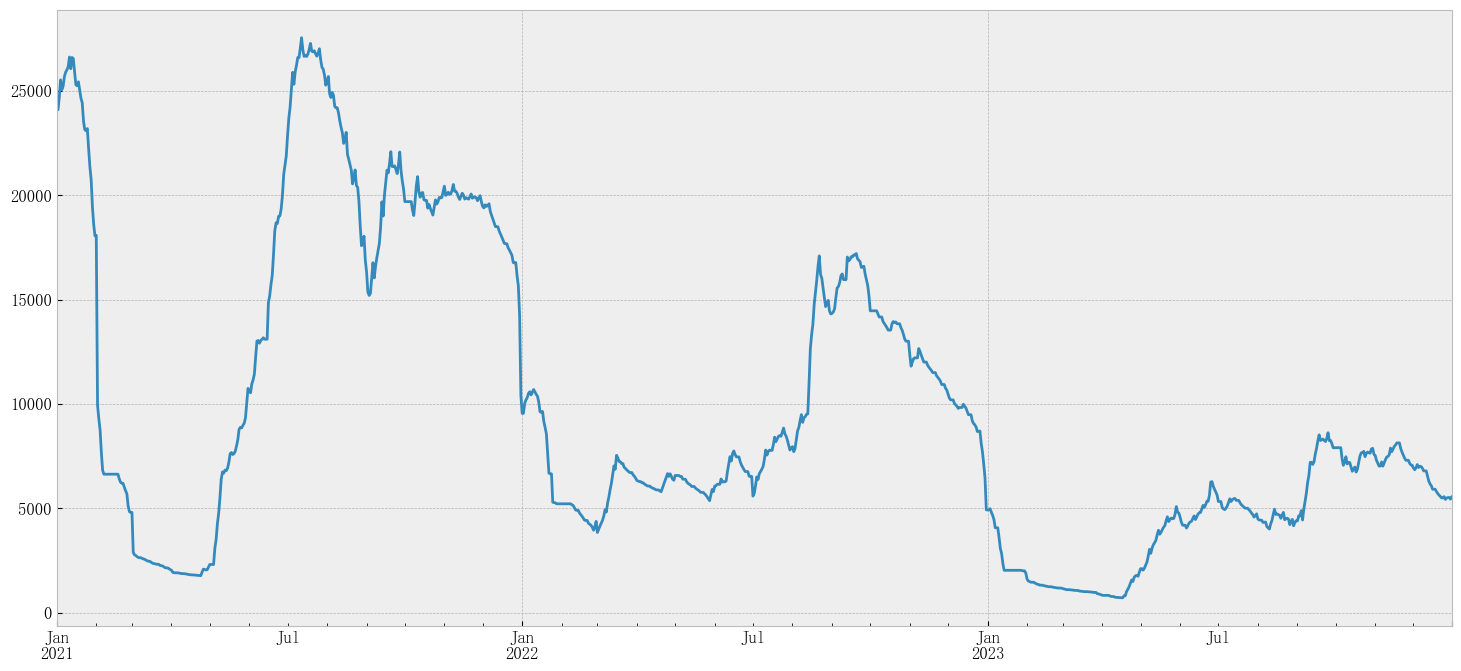

In [32]:
data["前一天在职人数"].plot()

Text(0.5, 1.0, '2021~2023年离厂人数序列图')

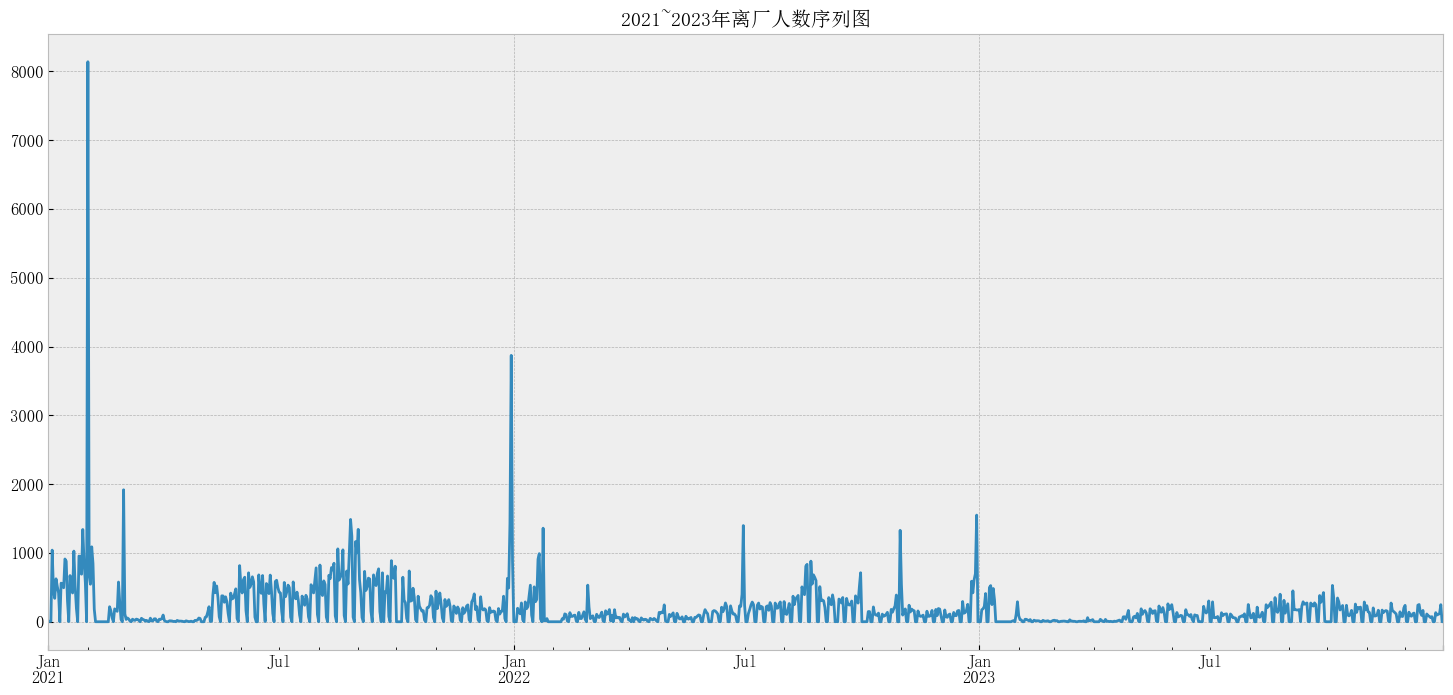

In [36]:
data["离职人数"].plot()
plt.title("2021~2023年离厂人数序列图")

In [34]:
data[data["离职人数"]>2000]

,离职人数,疫情等级,月份,lunar_year,lunar_month,lunar_day,离职人数比,前一天在职人数,前一天离职人数
2021-02-01,8140.0,1,2,2020,12,20,0.000000,18078,0.0
2021-12-30,3872.0,1,12,2021,11,27,0.100224,14258,1429.0


In [35]:
data.loc["2023-12-30":"2023-12-31"]

,离职人数,疫情等级,月份,lunar_year,lunar_month,lunar_day,离职人数比,前一天在职人数,前一天离职人数
2023-12-30,0.0,0,12,2023,11,18,0.045605,5438,248.0
2023-12-31,0.0,0,12,2023,11,19,0.000000,5540,0.0
